<a href="https://colab.research.google.com/github/jjungmini/-/blob/main/h2o_%EC%88%98%EC%9A%94%EC%98%88%EC%B8%A11_%EC%83%81%EC%98%A8%EC%A6%89%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install h2o
!pip install mxnet
!pip install xlsxwriter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.6/265.6 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.46.0.5-py2.py3-none-any.whl size=265646558 sha256=c875c744045900ba2ca69ea51da6c8a521aa889446ca1eee053d8022b5f4d2b8
  Stored in directory: /root/.cache/pip/wheels/1a/46/4f/9b366522399306d7849672d58aefb44c9b73378d710bde2853
Successfully built h2o
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 11.3 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 11.3 MB/s eta 0:00:00


In [2]:
# 필요한 라이브러리 임포트
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import h2o
from h2o.automl import H2OAutoML
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from prophet import Prophet

In [6]:
# 데이터 로드 및 전처리
data = pd.read_excel('merged_상온즉석.xlsx')

In [7]:
data.columns

Index(['Date', 'CCSI', 'RSI', 'CPI', 'year', 'month', 'day', 'week', 'temp',
       'precipitation', 'humidity', 'holidays', 'sales'],
      dtype='object')

DEBUG:cmdstanpy:input tempfile: /tmp/tmpjxnpgrap/e0cp16eh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjxnpgrap/d4g583bl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92858', 'data', 'file=/tmp/tmpjxnpgrap/e0cp16eh.json', 'init=/tmp/tmpjxnpgrap/d4g583bl.json', 'output', 'file=/tmp/tmpjxnpgrap/prophet_modelohgdcjqe/prophet_model-20241017025815.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:58:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:58:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


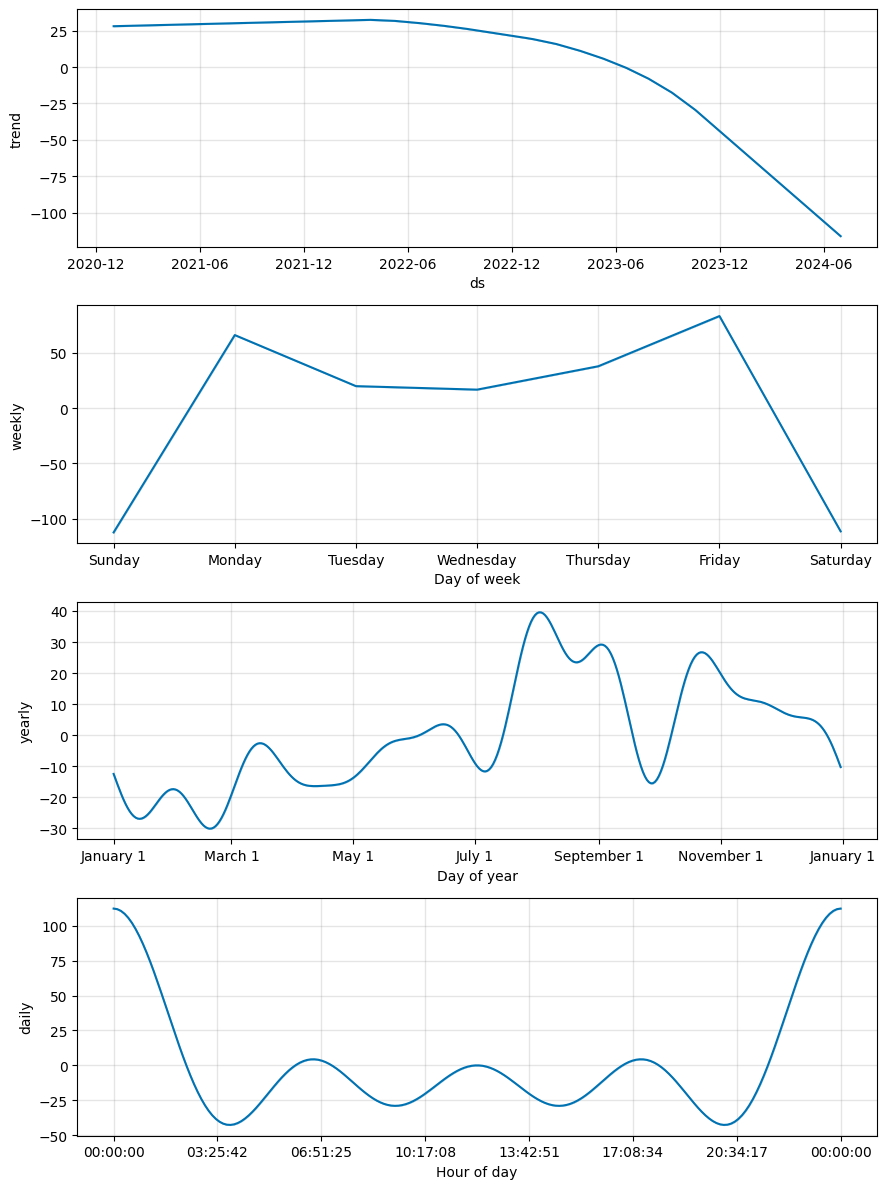

In [8]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

# Prophet에 맞게 데이터 포맷 변경 (날짜: 'ds', 판매수량: 'y')
prophet_data = data.rename(columns={'Date': 'ds', 'sales': 'y'})

# Prophet 모델 초기화 및 학습
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
model.fit(prophet_data)

# 미래 데이터프레임 생성 (예측 기간을 포함)
future = model.make_future_dataframe(periods=0)  # 분해만 하고 예측은 안함

# 분해 결과 예측 (추세와 계절성 포함)
forecast = model.predict(future)

# Prophet의 분해 그래프 시각화
fig = model.plot_components(forecast)
plt.show()

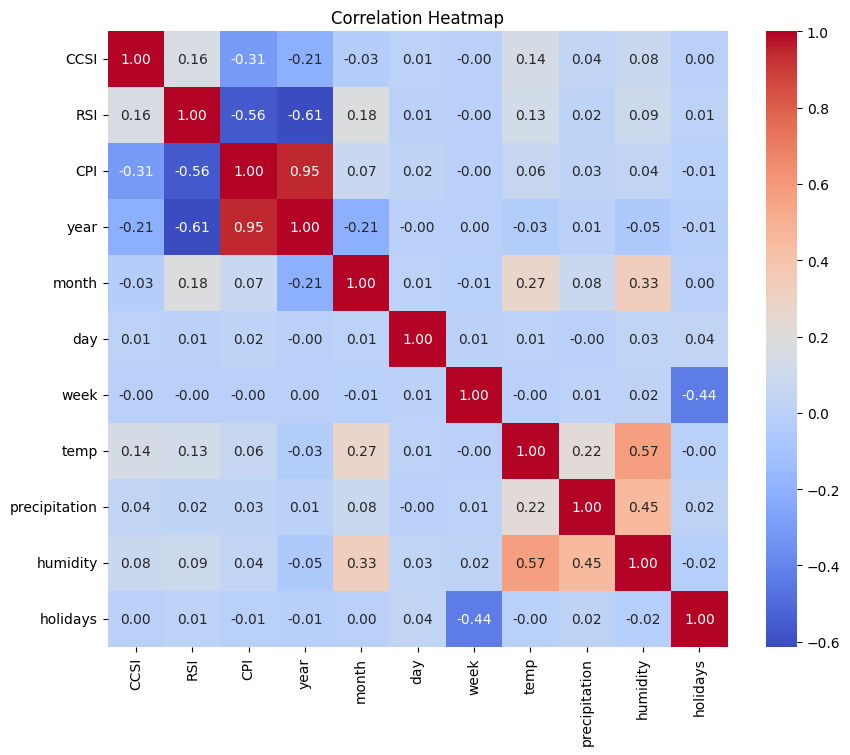

In [9]:
# 데이터 로드 및 전처리
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data['week'] = LabelEncoder().fit_transform(data['week'])
data['holidays'] = LabelEncoder().fit_transform(data['holidays'])

# 타겟 변수를 위한 별도의 스케일러 정의
target_scaler = StandardScaler()
data['sales'] = target_scaler.fit_transform(data[['sales']])

# 특성만 정규화하기 위해 Scaler 정의
scaler = StandardScaler()

# 특성들 간의 상관관계 계산을 위해 타겟 변수 제외
correlation_matrix = data.drop(columns=['Date', 'sales']).corr()

# 상관관계 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Solarpower 제외하고 정규화
features = data.drop(columns=['Date', 'sales'])
scaled_features = scaler.fit_transform(features)
data[features.columns] = scaled_features

# 훈련 데이터와 테스트 데이터로 분리
train = data[data['Date'] < '2023-07-01']
validation = data[(data['Date'] >= '2023-07-01') & (data['Date'] < '2024-01-01')]
test = data[data['Date'] >= '2024-01-01']

In [11]:
# 훈련 데이터를 이용하여 특성 선택을 위한 ElasticNetCV 모델을 생성합니다
enet_train = ElasticNetCV(
    alphas=[0.001, 0.01, 0.1, 1, 10],        # 후보 alpha 값 리스트
    l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9],     # 후보 l1_ratio 값 리스트
    cv=5,                                   # 5-fold cross-validation 사용
    n_alphas=1000,                           # 100개의 alpha 값 생성
    max_iter=1000,                          # 최대 반복 횟수
    tol=1e-5,                               # 수렴 기준
    verbose=False,                          # 로그 출력 비활성화
    precompute='auto',                      # 자동으로 사전 계산된 Gram 행렬 결정
    selection='random',                      # 랜덤하게 특성 선택
    random_state=42
)
enet_train.fit(train.drop(columns=['Date', 'sales', 'year', 'month', 'day']), train['sales'])
# alpha 값을 출력합니다.
print('Best alpha: ', enet_train.alpha_)

# 선택된 특성만 남김
selected_features_train = train.drop(columns=['Date', 'sales', 'year', 'month', 'day']).columns[enet_train.coef_ != 0]

# 선택된 특성 출력
print("Selected features: ", selected_features_train.tolist())

Best alpha:  0.1
Selected features:  ['CCSI', 'RSI', 'CPI', 'week', 'temp', 'precipitation', 'humidity', 'holidays']


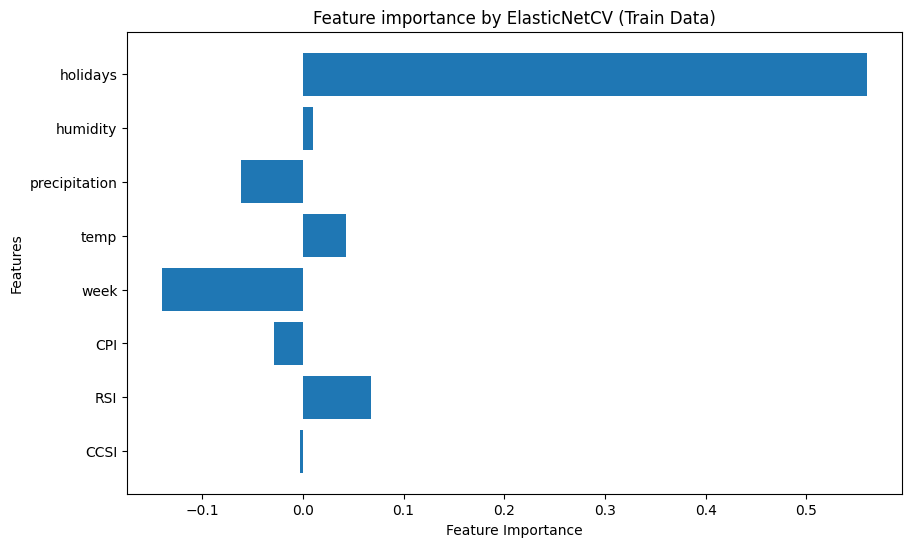

In [12]:
# ElasticNetCV의 결과를 출력합니다.
# 특성 중요도를 시각화합니다.
plt.figure(figsize=(10, 6))
plt.barh(range(len(enet_train.coef_)), enet_train.coef_)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.yticks(range(len(enet_train.coef_)), enet_train.feature_names_in_)
plt.title('Feature importance by ElasticNetCV (Train Data)')
plt.show()

In [13]:
train = train[['Date', 'sales', 'year', 'month', 'day'] + selected_features_train.tolist()]

In [14]:
enet_train.coef_

array([-0.00300209,  0.06801894, -0.02840907, -0.13955784,  0.04258001,
       -0.06138257,  0.00991829,  0.56021305])

# AutoML 학습을 위한 데이터셋 설정

In [15]:
# H2O 라이브러리 초기화
h2o.init()

# H2O 데이터프레임으로 변환
h2o_train = h2o.H2OFrame(train.drop('Date', axis=1))

# Date 열을 제외한 특성과 타겟 변수를 정의
x = h2o_train.columns
x.remove('sales')

y = 'sales'

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.24" 2024-07-16; OpenJDK Runtime Environment (build 11.0.24+8-post-Ubuntu-1ubuntu322.04); OpenJDK 64-Bit Server VM (build 11.0.24+8-post-Ubuntu-1ubuntu322.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp2hiu_u9n
  JVM stdout: /tmp/tmp2hiu_u9n/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp2hiu_u9n/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,1 month and 17 days
H2O_cluster_name:,H2O_from_python_unknownUser_dgh9xr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [16]:
# AutoML 설정 및 모델 훈련 (모든 파라미터를 원하는 값으로 변경하여 설정)
aml = H2OAutoML(
     max_runtime_secs=3600,     # AutoML 실행에 허용할 최대 시간 (초)
    # max_models=20,             # 생성할 최대 모델 수
    stopping_metric='RMSE',    # 조기 종료를 위한 평가 지표
    stopping_tolerance=0.01,  # 조기 종료를 위한 허용 오차
    stopping_rounds=3,         # 조기 종료를 위한 반복 횟수
    nfolds=3,                  # 교차 검증(fold)의 개수
    seed=42,                   # 랜덤 시드
    #exclude_algos = ["StackedEnsemble"],

   #include_algos=['Deeplearning'], #'DRF', 'XGBoost'],  # 사용할 알고리즘들의 리스트
    keep_cross_validation_predictions=True,  # 교차 검증 예측 결과 보존 여부
    keep_cross_validation_models=False,      # 교차 검증 모델 보존 여부
    keep_cross_validation_fold_assignment=False,  # 교차 검증 폴드 할당 보존 여부
    sort_metric='RMSE',        # 성능 측정 기준
    export_checkpoints_dir=None  # 모델 체크포인트를 내보낼 디렉토리
)

aml.train(x=x, y=y, training_frame=h2o_train)

AutoML progress: |
02:59:11.933: Stopping tolerance set by the user is < 70% of the recommended default of 0.03313147809612858, so models may take a long time to converge or may not converge at all.

███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),14/120
# GBM base models (used / total),3/32
# XGBoost base models (used / total),6/49
# DeepLearning base models (used / total),5/36
# DRF base models (used / total),0/2
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,3


In [17]:
# Automl 학습결과 확인

In [18]:
# AutoML 결과 확인 (모든 모델 출력)
lb = aml.leaderboard
print(lb)

# Leaderboard 데이터를 Pandas DataFrame으로 변환
leaderboard_df = lb.as_data_frame()

# 모든 모델의 성능 순위를 변수로 저장
for idx, row in leaderboard_df.iterrows():
    model_id = row['model_id']
    rank = idx + 1
    exec(f"model_rank_{rank} = h2o.get_model('{model_id}')")

# 모든 모델의 성능 순위 출력
print("\n<< 모든 모델의 성능 순위 >>")
for idx, row in leaderboard_df.iterrows():
    model_id = row['model_id']
    rank = idx + 1
    print(f"Model: {model_id}, Rank: {rank}")

model_id                                                    rmse       mse       mae       rmsle    mean_residual_deviance
StackedEnsemble_AllModels_6_AutoML_1_20241017_25911     0.720645  0.519329  0.438077  nan                         0.519329
StackedEnsemble_BestOfFamily_6_AutoML_1_20241017_25911  0.724094  0.524312  0.437832  nan                         0.524312
StackedEnsemble_BestOfFamily_4_AutoML_1_20241017_25911  0.724749  0.525261  0.437384  nan                         0.525261
StackedEnsemble_BestOfFamily_7_AutoML_1_20241017_25911  0.724924  0.525514  0.439157  nan                         0.525514
GBM_grid_1_AutoML_1_20241017_25911_model_95             0.726665  0.528042  0.445276  nan                         0.528042
GBM_grid_1_AutoML_1_20241017_25911_model_133            0.727536  0.529309  0.442402    0.588708                  0.529309
GBM_grid_1_AutoML_1_20241017_25911_model_137            0.728195  0.530268  0.450535  nan                         0.530268
GBM_grid_1_AutoM

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"



<< 모든 모델의 성능 순위 >>
Model: StackedEnsemble_AllModels_6_AutoML_1_20241017_25911, Rank: 1
Model: StackedEnsemble_BestOfFamily_6_AutoML_1_20241017_25911, Rank: 2
Model: StackedEnsemble_BestOfFamily_4_AutoML_1_20241017_25911, Rank: 3
Model: StackedEnsemble_BestOfFamily_7_AutoML_1_20241017_25911, Rank: 4
Model: GBM_grid_1_AutoML_1_20241017_25911_model_95, Rank: 5
Model: GBM_grid_1_AutoML_1_20241017_25911_model_133, Rank: 6
Model: GBM_grid_1_AutoML_1_20241017_25911_model_137, Rank: 7
Model: GBM_grid_1_AutoML_1_20241017_25911_model_103, Rank: 8
Model: StackedEnsemble_AllModels_2_AutoML_1_20241017_25911, Rank: 9
Model: StackedEnsemble_BestOfFamily_2_AutoML_1_20241017_25911, Rank: 10
Model: GBM_grid_1_AutoML_1_20241017_25911_model_65, Rank: 11
Model: GBM_grid_1_AutoML_1_20241017_25911_model_63, Rank: 12
Model: StackedEnsemble_Best1000_1_AutoML_1_20241017_25911, Rank: 13
Model: GBM_grid_1_AutoML_1_20241017_25911_model_56, Rank: 14
Model: GBM_grid_1_AutoML_1_20241017_25911_model_11, Rank: 15
Mode

In [19]:
# 순위별로 모델에 대한 세부 정보 출력
# n등의 모델을 출력하려면 : print(model_rank_n)
print(model_rank_1)

Model Details
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_6_AutoML_1_20241017_25911


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       14/120
# GBM base models (used / total)           3/32
# XGBoost base models (used / total)       6/49
# DeepLearning base models (used / total)  5/36
# DRF base models (used / total)           0/2
# GLM base models (used / total)           0/1
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         3
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.21560594905043848
RMSE: 0.4643338766991253
MAE: 0.2819594182387655
RMSLE: 0.41088775

In [ ]:
# AutoML 결과 확인 (모든 모델 출력)
lb = aml.leaderboard
print(lb)

# Leaderboard 데이터를 Pandas DataFrame으로 변환
leaderboard_df = lb.as_data_frame()

# Excel 파일 생성
writer = pd.ExcelWriter('train_result_라면.xlsx', engine='xlsxwriter')

# 모든 모델의 파라미터 정보를 저장하는 새로운 열을 추가합니다.
all_parameters = []
for index, row in leaderboard_df.iterrows():
    model_id = row['model_id']
    model = h2o.get_model(model_id)
    model_params = model.params
    all_parameters.append(model_params)

leaderboard_df['Parameters'] = all_parameters

# DataFrame을 첫 번째 시트로 저장합니다.
leaderboard_df.to_excel(writer, sheet_name='Leaderboard', index=True)



# 엑셀 파일 저장
writer.save()

model_id                                                                      rmse       mse       mae    rmsle    mean_residual_deviance
StackedEnsemble_BestOfFamily_6_AutoML_1_20241016_151118                   0.545687  0.297774  0.358815      nan                  0.297774
GBM_grid_1_AutoML_1_20241016_151118_model_35                              0.545905  0.298012  0.362927      nan                  0.298012
GBM_grid_1_AutoML_1_20241016_151118_model_222                             0.547657  0.299928  0.356824      nan                  0.299928
StackedEnsemble_BestOfFamily_4_AutoML_1_20241016_151118                   0.548129  0.300446  0.362094      nan                  0.300446
XGBoost_lr_search_selection_AutoML_1_20241016_151118_select_grid_model_4  0.549623  0.302086  0.360583      nan                  0.302086
StackedEnsemble_AllModels_6_AutoML_1_20241016_151118                      0.549708  0.302179  0.359789      nan                  0.302179
GBM_grid_1_AutoML_1_20241016_15111

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


AttributeError: 'XlsxWriter' object has no attribute 'save'

# 모델 학습 결과 시각화 용

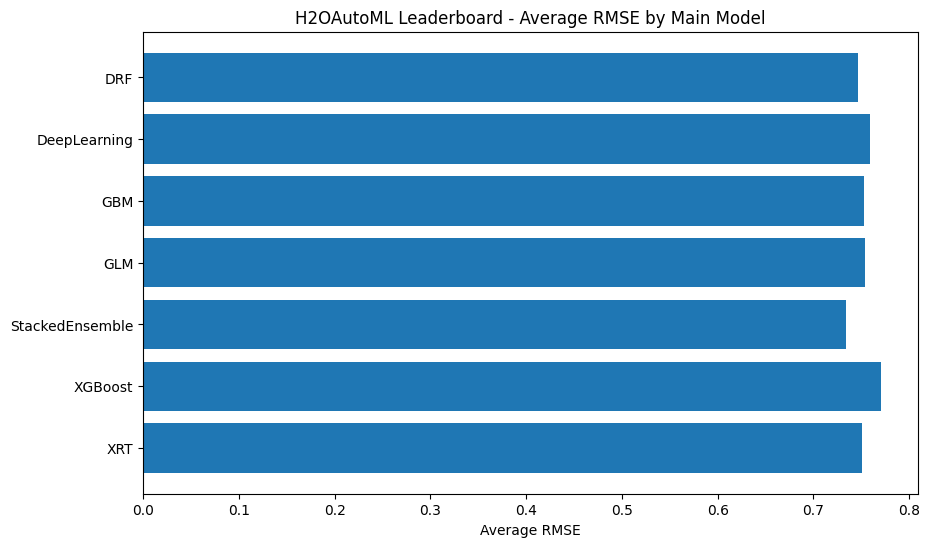

In [20]:
import matplotlib.pyplot as plt

# 메인 모델(model_id 앞의 첫 단어)을 기준으로 데이터를 그룹화
grouped_leaderboard = leaderboard_df.groupby(leaderboard_df['model_id'].str.split('_').str[0])

# 각 그룹별 평균값 계산
group_means = grouped_leaderboard['rmse'].mean()

# 그룹 평균값을 시각화하여 비교
plt.figure(figsize=(10, 6))
plt.barh(group_means.index, group_means.values)
plt.xlabel('Average RMSE')
plt.title('H2OAutoML Leaderboard - Average RMSE by Main Model')
plt.gca().invert_yaxis()  # 모델 순위를 높은 순서대로 표시
plt.show()

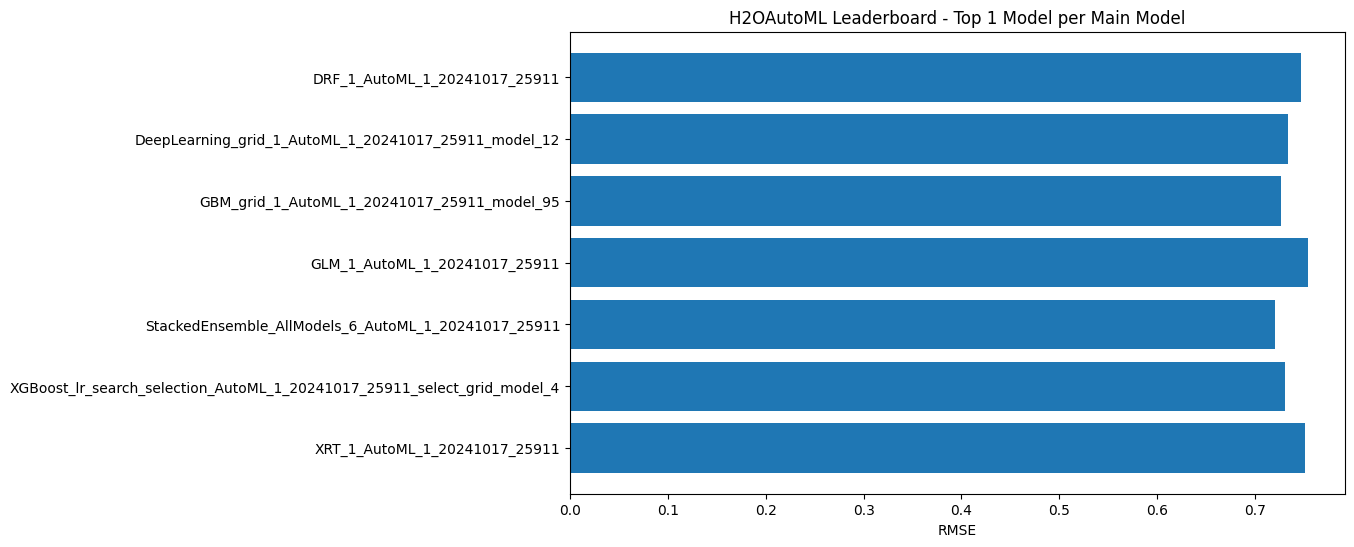

In [21]:
import matplotlib.pyplot as plt

# 메인 모델(model_id 앞의 첫 단어)을 기준으로 데이터를 그룹화
grouped_leaderboard = leaderboard_df.groupby(leaderboard_df['model_id'].str.split('_').str[0])

# 각 그룹별 1위 모델 선택 (가장 낮은 RMSE 값을 가진 모델)
top_1_models = grouped_leaderboard.apply(lambda group: group.nsmallest(1, 'rmse'))

# 메인 모델별 1위 모델의 RMSE를 시각화하여 비교
plt.figure(figsize=(10, 6))
plt.barh(top_1_models['model_id'], top_1_models['rmse'])
plt.xlabel('RMSE')
plt.title('H2OAutoML Leaderboard - Top 1 Model per Main Model')
plt.gca().invert_yaxis()  # 모델 순위를 높은 순서대로 표시
plt.show()

# best 모델 출력하고, 예측을 위한 df 변환

In [22]:
# 가장 성능이 좋은 모델 선택
best_model = aml.leader

# 선택된 특성 출력
print("Best model is: ", best_model)

Best model is:  Model Details
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_6_AutoML_1_20241017_25911


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       14/120
# GBM base models (used / total)           3/32
# XGBoost base models (used / total)       6/49
# DeepLearning base models (used / total)  5/36
# DRF base models (used / total)           0/2
# GLM base models (used / total)           0/1
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         3
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.21560594905043848
RMSE: 0.4643338766991253
MAE: 0.2819594182387655
R

In [23]:
# MAPE 계산 함수 정의
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 선택된 특성만 남김('Precipitation', 'Dewpoint' 제거)
validation = validation[['Date', 'sales', 'year', 'month', 'day'] + selected_features_train.tolist()]

In [24]:
validation

,Date,sales,year,month,day,CCSI,RSI,CPI,week,temp,precipitation,humidity,holidays
911,2023-07-01,-0.883832,0.694267,0.264327,-1.673557,0.312478,0.682870,0.721732,0.999804,1.238288,-0.339819,0.998531,-1.436088
912,2023-07-02,-0.883832,0.694267,0.264327,-1.559819,0.326628,0.624062,0.722705,0.499902,1.418103,-0.343200,0.701524,-1.436088
913,2023-07-03,0.669577,0.694267,0.264327,-1.446081,0.340777,0.565255,0.723677,0.000000,1.306127,-0.343200,0.785817,0.696336
914,2023-07-04,0.049782,0.694267,0.264327,-1.332344,0.354926,0.506447,0.724649,1.499706,1.179439,2.108879,1.343139,0.696336
915,2023-07-05,-0.075746,0.694267,0.264327,-1.218606,0.369075,0.447640,0.725622,-0.499902,1.328195,1.910245,0.631611,0.696336
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,2023-12-27,-0.562167,0.694267,1.724302,1.283624,0.060512,-0.730295,1.083288,-0.499902,-1.178589,-0.343200,0.250311,0.696336
1091,2023-12-28,0.316529,0.694267,1.724302,1.397362,0.073572,-0.721384,1.083662,-0.999804,-1.195753,-0.343200,0.003879,0.696336
1092,2023-12-29,0.238074,0.694267,1.724302,1.511100,0.086633,-0.712474,1.084036,-1.499706,-1.210465,-0.343200,0.042555,-1.436088
1093,2023-12-30,-0.883832,0.694267,1.724302,1.624838,0.099694,-0.703564,1.084410,0.999804,-1.149982,-0.293330,0.486330,-1.436088


In [25]:
# 테스트 데이터를 H2O 데이터프레임으로 변환
h2o_validation = h2o.H2OFrame(validation.drop('Date', axis=1))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# 원하는 rank의 모델 사용하여 validation data 예측 수행

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
평균 제곱 오차 (MSE): 5913.179461133509
평균 절대 오차 (MAE): 51.00358265735541
결정 계수 (R2): 0.5393253883069367
평균 절대 백분율 오차 (MAPE): inf
평균 제곱근 오차 (RMSE): 76.89720060661188


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
<ipython-input-23-0ce6155229ef>:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


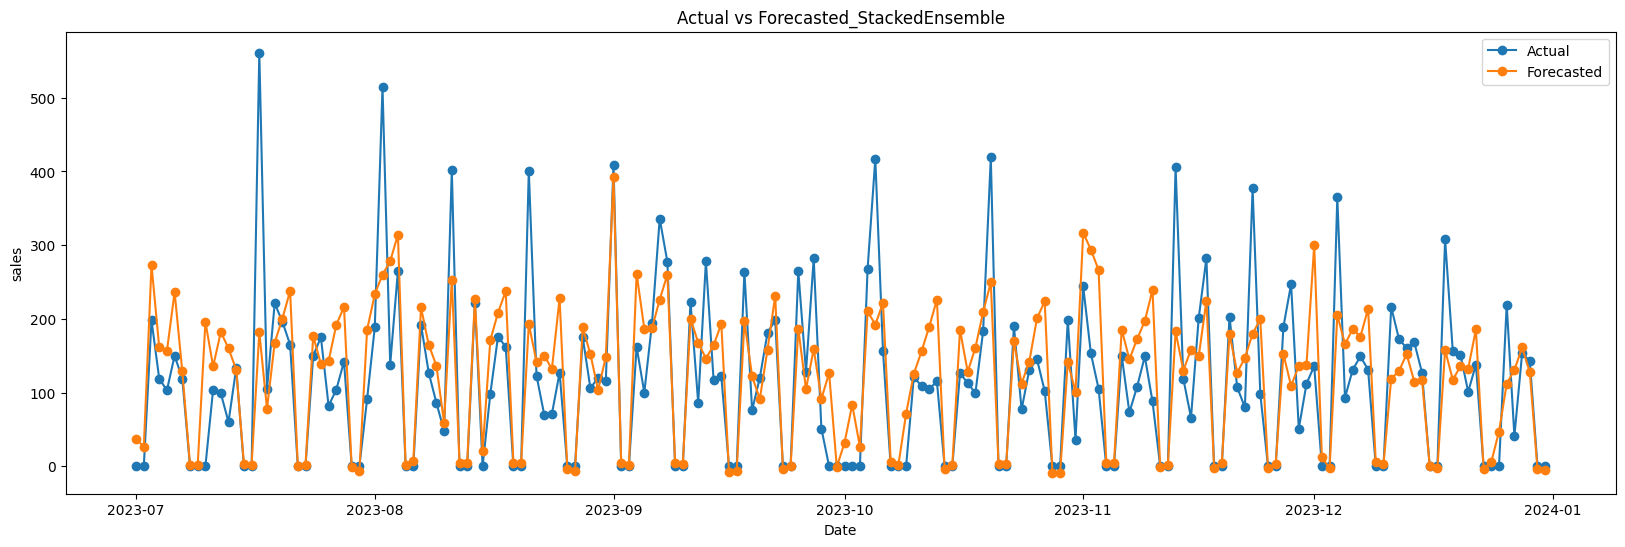

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
평균 제곱 오차 (MSE): 5967.896952824712
평균 절대 오차 (MAE): 49.58098056779265
결정 계수 (R2): 0.5350625447042109
평균 절대 백분율 오차 (MAPE): inf
평균 제곱근 오차 (RMSE): 77.25216471287204


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
<ipython-input-23-0ce6155229ef>:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


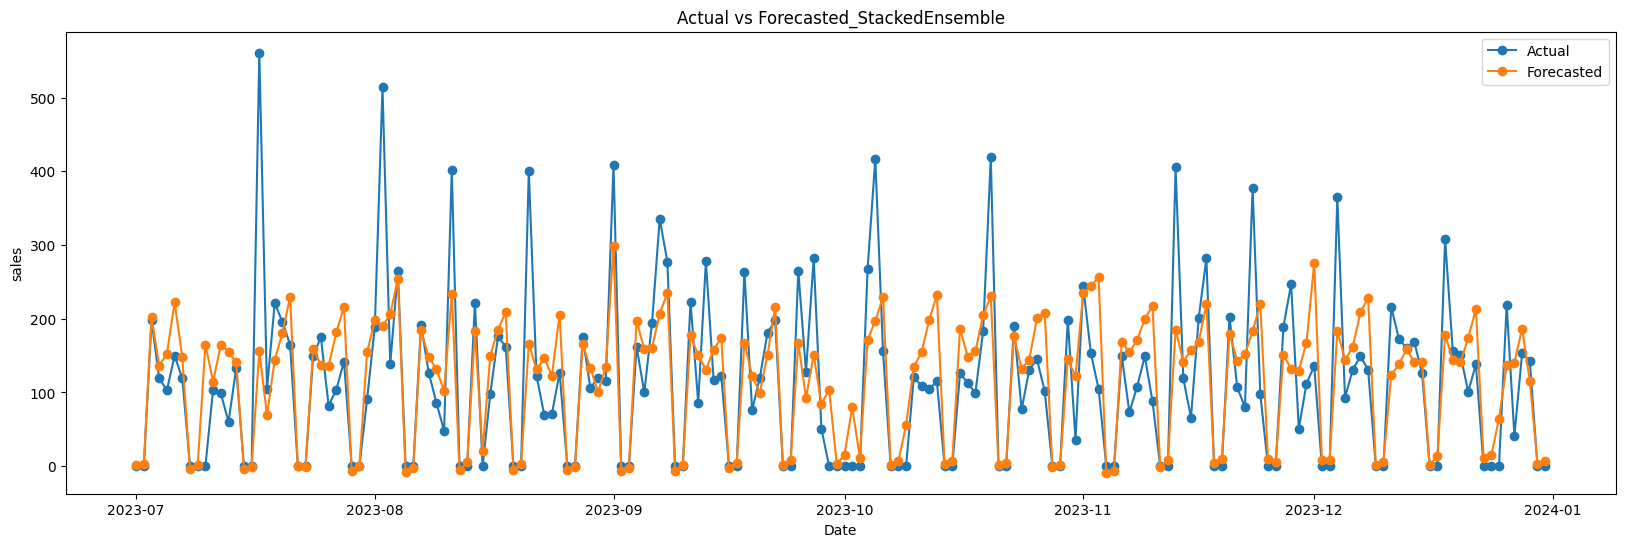

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
평균 제곱 오차 (MSE): 6049.785039324982
평균 절대 오차 (MAE): 50.68898755339533
결정 계수 (R2): 0.5286829374728131
평균 절대 백분율 오차 (MAPE): inf
평균 제곱근 오차 (RMSE): 77.78036409869127


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
<ipython-input-23-0ce6155229ef>:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


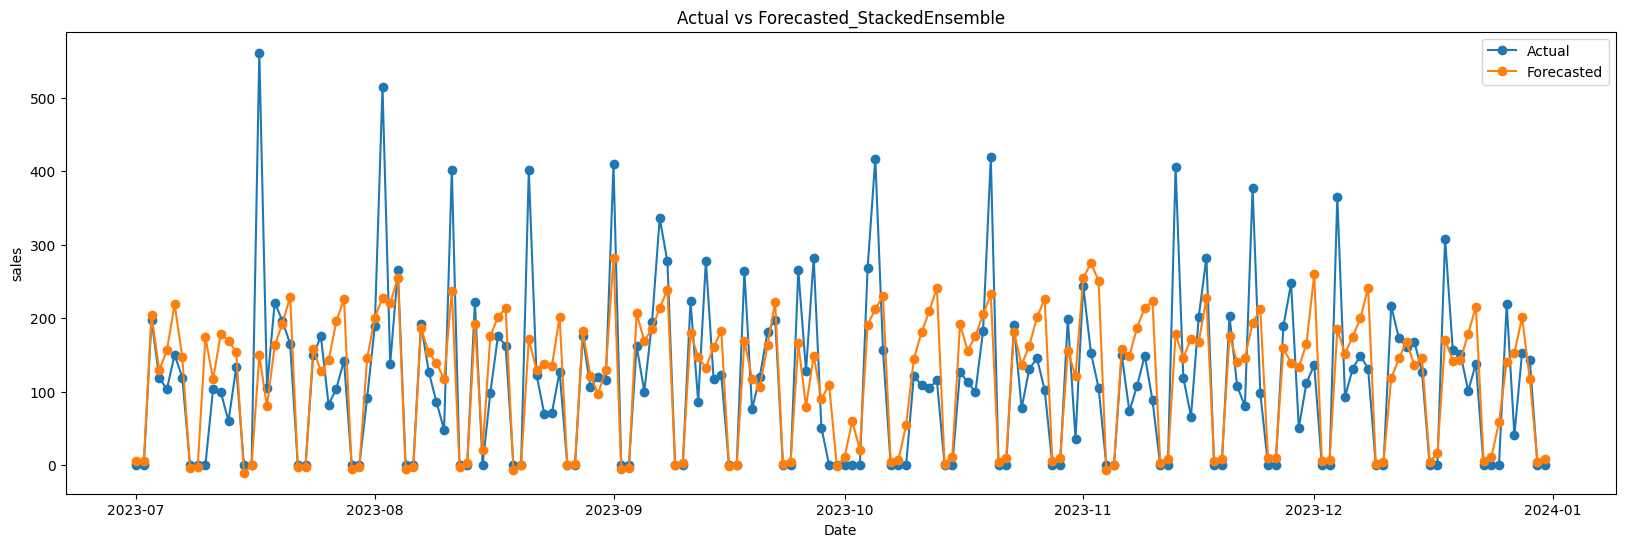

In [26]:
all_predictions = pd.DataFrame()
all_evaluations = pd.DataFrame()
for i in [model_rank_1, model_rank_3, model_rank_4]:
  # 원하는 rank의 모델을 사용하여 예측 수행
  predictions = i.predict(h2o_validation) #model_rank_n
  predictions = predictions.as_data_frame()

  # 예측된 값을 원래 스케일로 역변환
  predictions = target_scaler.inverse_transform(predictions)

  # 테스트 데이터셋의 실제 타겟 변수 값을 가져옴
  actual_values = validation['sales'].values.reshape(-1, 1)
  actual_values = target_scaler.inverse_transform(actual_values)

  # 각 rank의 값의 모델명을 파일명으로 사용
  name_index = i.model_id.find("_")
  model_name = i.model_id[:name_index]

  # 평가 지표 계산
  mse = mean_squared_error(actual_values, predictions)
  mae = mean_absolute_error(actual_values, predictions)
  r2 = r2_score(actual_values, predictions)
  mape = mean_absolute_percentage_error(actual_values, predictions)
  rmse = np.sqrt(mse)

  # 평가 지표 출력
  print("평균 제곱 오차 (MSE):", mse)
  print("평균 절대 오차 (MAE):", mae)
  print("결정 계수 (R2):", r2)
  print("평균 절대 백분율 오차 (MAPE):", mape)
  print("평균 제곱근 오차 (RMSE):", rmse)

  # 실제 값과 예측값 시각화
  plt.figure(figsize=(20, 6))
  plt.plot(validation['Date'], actual_values, label='Actual', marker='o')
  plt.plot(validation['Date'], predictions, label='Forecasted', marker='o')
  plt.xlabel('Date')
  plt.ylabel('sales')
  plt.title(f'Actual vs Forecasted_{model_name}')
  plt.legend()
  plt.show()

  # 모든 평가지표를 데이터프레임으로 저장
  all_evaluations[model_name] = [mse, mae, r2, mape, rmse]

  # 모든 예측값 저장
  all_predictions[model_name] = predictions[:,0]



# 엑셀 파일로 저장
all_evaluations.to_excel('평가_validation_상온즉석.xlsx', index=False)

# 예측값 파일 저장
file_name = '예측값_validation_상온즉석.xlsx'
all_predictions.to_excel(file_name, index=False)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51593 (\N{HANGUL SYLLABLE JEUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist

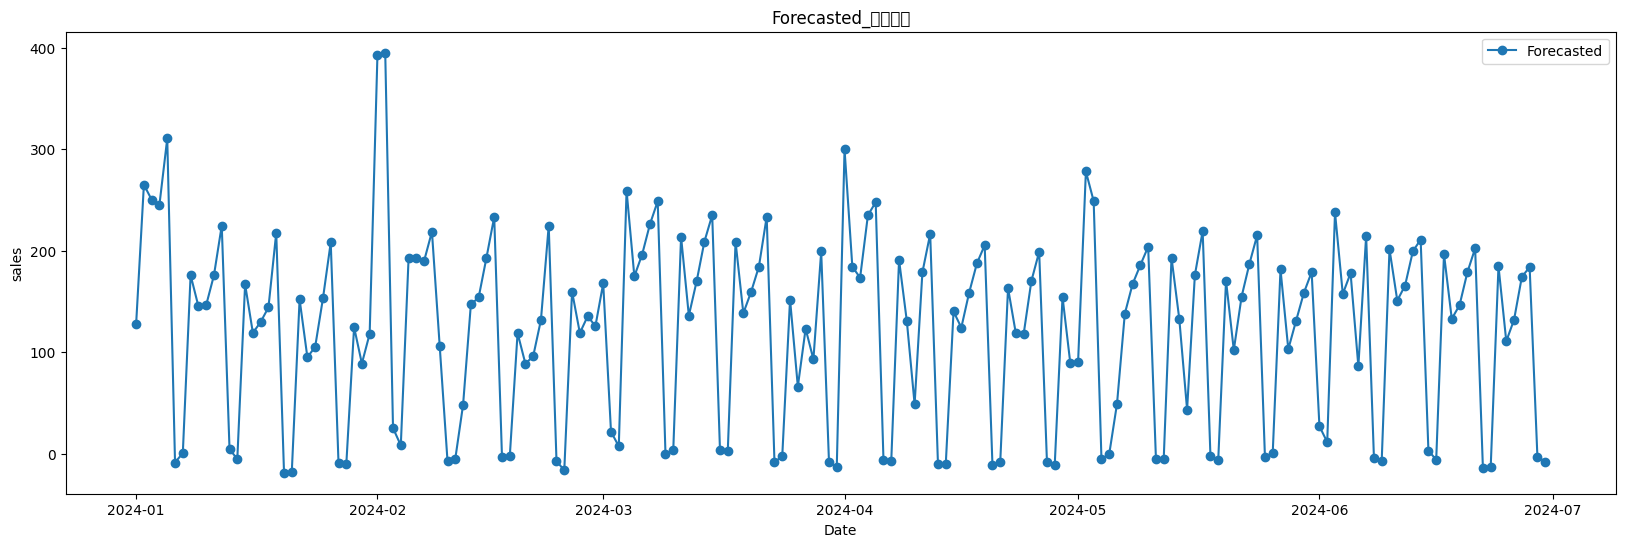

In [27]:
all_predictions = pd.DataFrame()

# 선택된 특성만 남김('Precipitation', 'Dewpoint' 제거)
test = test[['Date', 'sales', 'year', 'month', 'day'] + selected_features_train.tolist()]

# 테스트 데이터를 H2O 데이터프레임으로 변환
h2o_test = h2o.H2OFrame(test.drop('Date', axis=1))
predictions = model_rank_1.predict(h2o_test) #model_rank_n
predictions = predictions.as_data_frame()

# 예측된 값을 원래 스케일로 역변환
predictions = target_scaler.inverse_transform(predictions)

# 각 rank의 값의 모델명을 파일명으로 사용
name_index = model_rank_1.model_id.find("_")
model_name = model_rank_1.model_id[:name_index]

# 실제 값과 예측값 시각화
plt.figure(figsize=(20, 6))
plt.plot(test['Date'], predictions, label='Forecasted', marker='o')
plt.xlabel('Date')
plt.ylabel('sales')
plt.title('Forecasted_상온즉석')
plt.legend()
plt.show()

# 모든 예측값 저장
all_predictions[model_name] = predictions[:,0]

# 예측값 파일 저장
file_name = '예측값_상온즉석.xlsx'
all_predictions.to_excel(file_name, index=False)